In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from tqdm.auto import tqdm
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline

In [2]:
data_after = pd.read_csv('date_after_test.csv', index_col = 'id')
data_after.head(3)

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_990,hour_991,hour_992,hour_993,hour_994,hour_995,hour_996,hour_997,hour_998,uid
id,,,,,,,,,,,,,,,,,,,,,
2827,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2827
2864,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2864
2828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2828


In [3]:
data_after.sort_values(by = 'id', inplace = True)

data_after.drop(['uid'], axis = 1, inplace = True)

In [4]:
data_before = pd.read_csv('data_before_test.csv', index_col = 'id')
data_before.head(3)

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_990,hour_991,hour_992,hour_993,hour_994,hour_995,hour_996,hour_997,hour_998,uid
id,,,,,,,,,,,,,,,,,,,,,
1858,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1858
1865,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1865
1860,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1860


In [5]:
data_before.sort_values(by = 'id', inplace = True) 

data_before.drop(['uid'], axis = 1, inplace = True)

In [6]:
# Конверсию я считал по формуле количество целевых посещений (1) делить на
# Общеее количество посещений (0 и 1)

# Датафрейм с посчитанной конверсией
data_before_conversion = pd.DataFrame(data_before.sum(axis = 1) / data_before.notna().sum(axis = 1), columns = ['conversion'])

data_after_conversion = pd.DataFrame(data_after.sum(axis = 1) / data_after.notna().sum(axis = 1), columns = ['conversion'])

In [7]:
before_A1 = data_before_conversion.iloc[:5000]
before_A2 = data_before_conversion.iloc[5000:]

after_A = data_after_conversion.iloc[:5000]
after_B = data_after_conversion.iloc[5000:]

### АА-тест
Перед проведением AB-теста, убедимся, что мы разделили пользователей на две равномерные группы.
Для этого проведем АА-тест, проверим не имеют ли наши группы статистических различий в конверсии при одинаковых условиях.

In [11]:
t = PowerTransformer(method='box-cox')

# Трансформирую данные добавляя +1 чтобы избежать нулевых значений
before_A1_t = pd.Series(t.fit_transform(before_A1 + 1).flatten())
before_A2_t = pd.Series(t.fit_transform(before_A2 + 1).flatten())

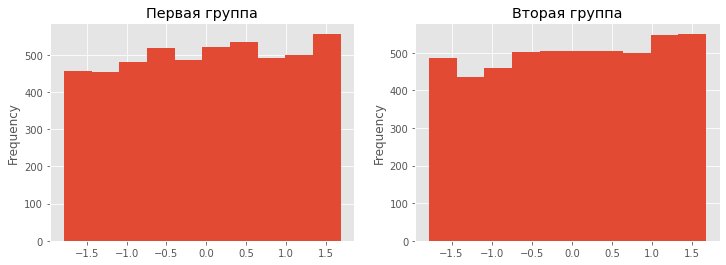

In [12]:
fig, axes = plt.subplots(1, 2)

before_A1_t.plot(kind = 'hist', ax = axes[0],
               figsize = (12,4),
               title = 'Первая группа')

before_A2_t.plot(kind = 'hist',
               ax = axes[1],
               figsize = (12,4),
               title = 'Вторая группа');

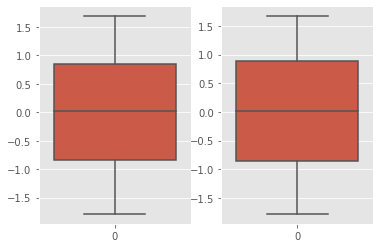

In [14]:
fig, axes = plt.subplots(1, 2)
sns.boxplot(data=before_A1_t, ax = axes[0])
sns.boxplot(data=before_A2_t, ax = axes[1]);

In [19]:
# Средние по выборкам
m1 = np.mean(before_A1_t.values)
m2 = np.mean(before_A2_t.values)

# Нижние и верхние границы 95% доверительного интервала
lcb_a1 = before_A1_t.quantile(0.025)
ucb_a1 = before_A1_t.quantile(0.975)

lcb_a2 = before_A2_t.quantile(0.025)
ucb_a2 = before_A2_t.quantile(0.975)

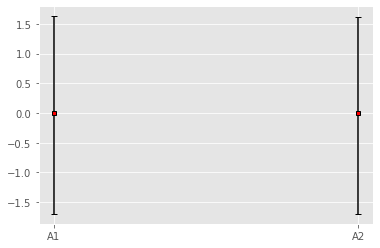

In [20]:
# График доверительных интервалов
bplot2 = plt.errorbar(x=['A1', 'A2'],
                      y=[m1, m2],
                      yerr=[[m1 - lcb_a1, m2 - lcb_a2],[ucb_a1 - m1, ucb_a2 - m2]],
                      color="black", capsize=3,
                      marker="s",markersize=4,
                      mfc="red", mec="black", fmt ='o')

Использую bootstrap в качестве второй проверки. Код функции get_bootstrap был позаимствован из материалов Анатолия Карпова
https://www.youtube.com/watch?v=-zps6hm0nX8&t=3036s

In [25]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { "quants": quants, 
            "p_value": p_value}

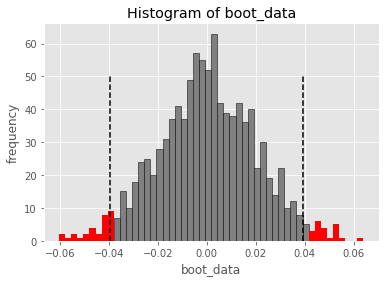

{'quants':               0
 0.025 -0.039426
 0.975  0.039467,
 'p_value': 0.9943013366020584}

In [26]:
get_bootstrap(
    before_A1_t, # числовые значения первой выборки
    before_A2_t, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

#### Тест не показал стат. значимого различия

Из этого следует, что мы разделили пользователей на две равномерные группы и можем проводить АВ-тест.

## АВ-тест

In [27]:
# Трансформирую данные добавляя +1 чтобы избежать нулевых значений
after_A_t = pd.Series(t.fit_transform(after_A + 1).flatten())
after_B_t = pd.Series(t.fit_transform(after_B + 1).flatten())

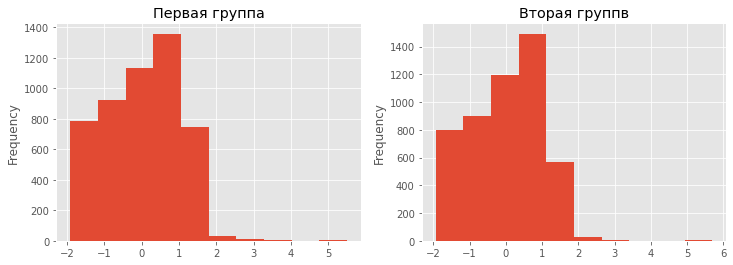

In [28]:
fig, axes = plt.subplots(1, 2)

after_A_t.plot(kind = 'hist', ax = axes[0],
                            figsize = (12,4),
                            title = 'Первая группа')

after_B_t.plot(kind = 'hist',
                           ax = axes[1],
                           figsize = (12,4),
                           title = 'Вторая группв');

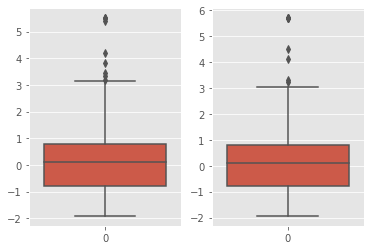

In [29]:
fig, axes = plt.subplots(1, 2)
sns.boxplot(data=after_A_t, ax = axes[0])
sns.boxplot(data=after_B_t, ax = axes[1]);

In [30]:
# Средние по выборкам
m1 = np.mean(after_A_t.values)
m2 = np.mean(after_B_t.values)

# Нижние и верхние границы 95% доверительного интервала
lcb_a1 = after_A_t.quantile(0.025)
ucb_a1 = after_A_t.quantile(0.975)

lcb_a2 = after_B_t.quantile(0.025)
ucb_a2 = after_B_t.quantile(0.975)

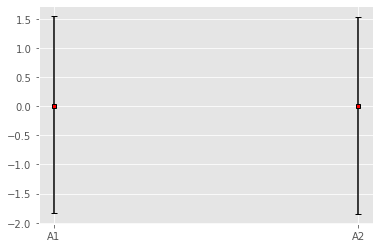

In [31]:
# График доверительных интервалов
bplot2 = plt.errorbar(x=['A1', 'A2'],
                      y=[m1, m2],
                      yerr=[[m1 - lcb_a1, m2 - lcb_a2],[ucb_a1 - m1, ucb_a2 - m2]],
                      color="black", capsize=3,
                      marker="s",markersize=4,
                      mfc="red", mec="black", fmt ='o')

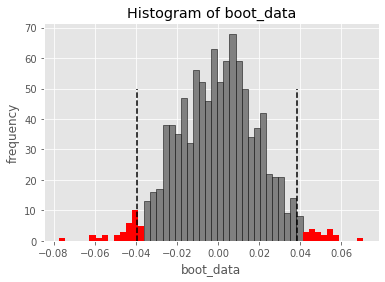

{'quants':               0
 0.025 -0.039448
 0.975  0.038621,
 'p_value': 0.9946521366188972}

In [32]:
get_bootstrap(
    after_A_t, # числовые значения первой выборки
    after_B_t, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Тест не показал статистически значимых отличий в выборках

##### Вывод: Среднее значение конверсии на пользователя в группе А и В не имеют стат. значимых отличий